# Loading & Preprocessing Tables

__Libraries__

In [11]:
import pandas as pd
import numpy as np
import re

from sklearn.cluster import AffinityPropagation
import distance

import pgeocode
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,7)
from sklearn.preprocessing import OrdinalEncoder

import random
random.seed(42)

## Rating Data

In [12]:
ratings = pd.read_csv("./Data/ratings.csv")
ratings.shape

(100836, 4)

Check if one rating of a movie per each user: 

In [13]:
(ratings.groupby(['userId', 'movieId']).rating.count() != 1).sum()

0

Check how many users rated each movie: 

<AxesSubplot:>

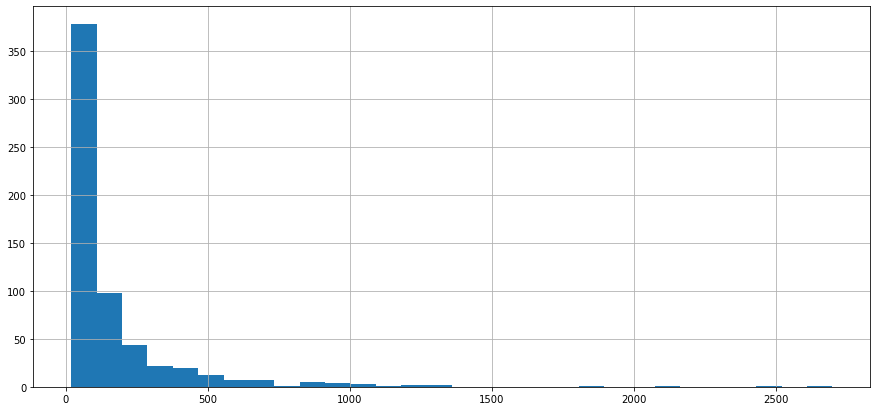

In [14]:
ratings.groupby('userId').movieId.size().hist(bins=30)

In [15]:
ratings.groupby('userId').movieId.size().describe()

count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: movieId, dtype: float64

We have 610 users, more than half rated 70 movies. We have some extreme values, of users that rated over 1,000 movis, which seems a lot. See if there is variance in their ratings

In [16]:
outlier_users = ratings.groupby('userId').movieId.size()[ratings.groupby('userId').movieId.size() > 1000].index
outlier_user_ratings = ratings[ratings.userId.isin(outlier_users)].groupby('userId').rating.agg(lambda x: list(x))

In [17]:
outlier_user_ratings.apply(lambda x: pd.Series(x).describe())

,count,mean,std,min,25%,50%,75%,max
userId,,,,,,,,
68,1260.0,3.233730,0.896740,0.5,2.5,3.25,4.0,5.0
249,1046.0,3.696463,0.672691,0.5,3.5,3.50,4.0,5.0
274,1346.0,3.235884,0.761703,0.5,3.0,3.50,3.5,5.0
288,1055.0,3.145972,0.866584,1.0,3.0,3.00,4.0,5.0
380,1218.0,3.673235,0.961010,0.5,3.0,4.00,4.0,5.0
387,1027.0,3.258520,0.859310,0.5,3.0,3.50,4.0,5.0
414,2698.0,3.391957,0.933307,0.5,3.0,3.50,4.0,5.0
448,1864.0,2.847371,1.029706,0.5,2.0,3.00,3.5,5.0
474,2108.0,3.398956,0.830847,0.5,3.0,3.50,4.0,5.0


The problem with this is that almost 20% of observations come from 12 users: 

In [18]:
print(f'''
Number of Users: {outlier_user_ratings.shape[0]}
Percentage of Total Rated Movies: {outlier_user_ratings.apply(lambda x: pd.Series(x).describe())['count'].sum()/ratings.shape[0]}
''')


Number of Users: 12
Percentage of Total Rated Movies: 0.1836348129636241



The issues with this, is that the subjectivity of a few will dominate over the predictions of the model. 

__Possible Solution__: Consider sampling the number of rated movies from these extreme cases that rated almost every movie

In [19]:
remove_indexes = []
for user in outlier_users: 
    remove_indexes.extend(random.sample(sorted(ratings[ratings.userId == user].index), sum(ratings.userId == user) - 1000))
ratings['sample_ratings'] = ratings.index.isin(remove_indexes)

Check the distribution of the ratings: 

<AxesSubplot:>

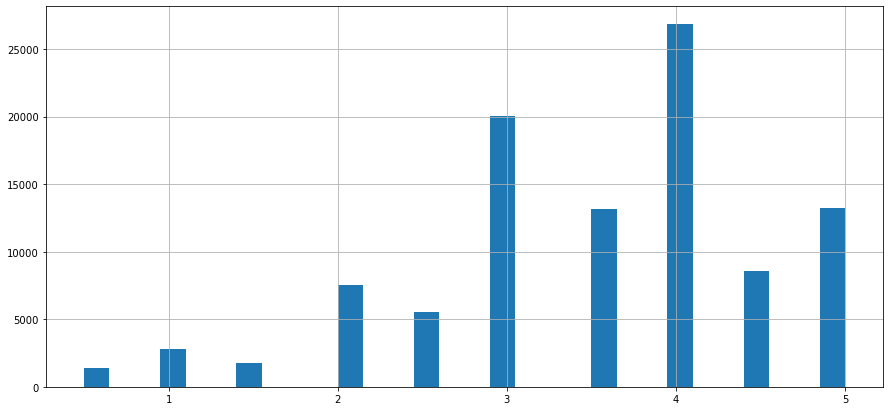

In [20]:
ratings.rating.hist(bins=30)

- Not a lot of users use decimals 0.5 to rate the movies (consider including them in the rounding to the nearest decimal)
- Most movies are rated 3/4 (not many ratings in the extremes of the domain of the dependent variable)

Create new rating variable with rounded numbers: 

<AxesSubplot:>

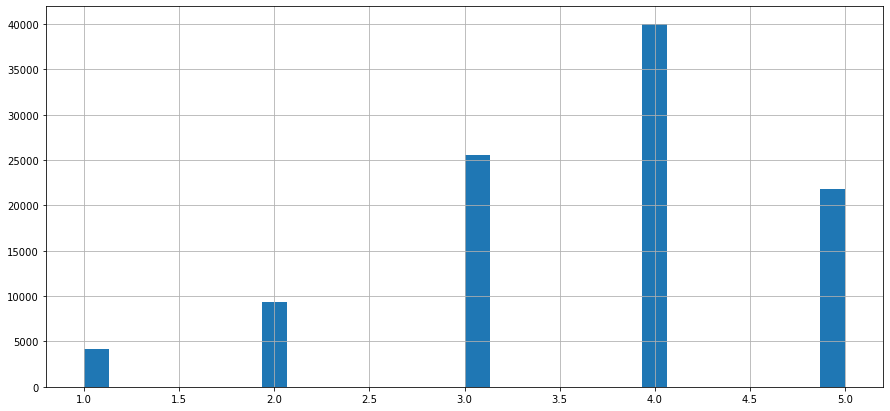

In [21]:
ratings['ratings2'] = ratings.rating.apply(lambda x: int(round(x + 0.01, 0)))
ratings.ratings2.hist(bins=30)

Check average rating by user: 

<AxesSubplot:>

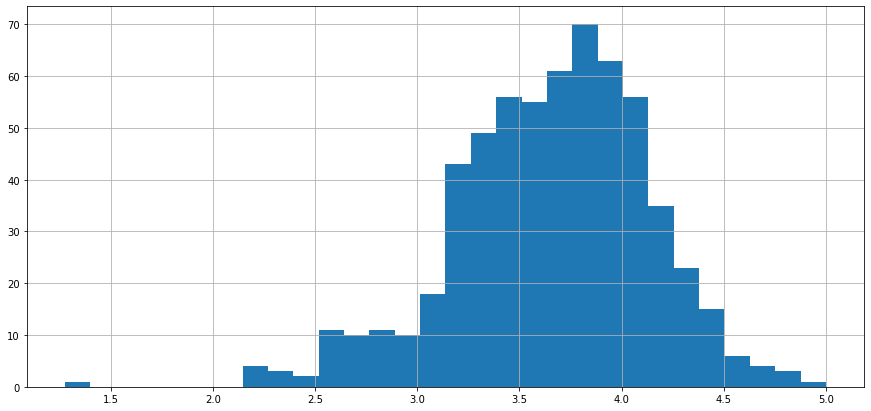

In [22]:
ratings.groupby('userId').rating.mean().hist(bins=30)

The average rating per users seems to follow a normal distribution. There is an outlier observation of a user that puts very bad ratings. Check it out

In [23]:
ratings.groupby('userId').rating.mean().nsmallest(2)

userId
442    1.27500
139    2.14433
Name: rating, dtype: float64

<AxesSubplot:>

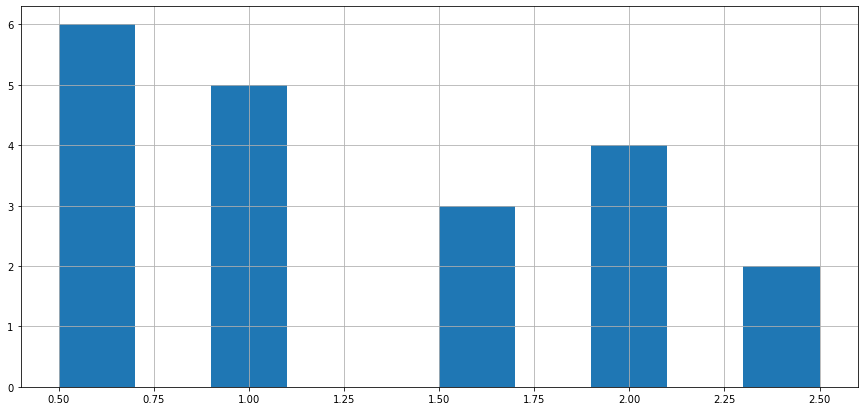

In [24]:
ratings[ratings.userId == 442].rating.hist()

This is a black sheep that does not consider good ratings. 

__Possible Solution__: consider excluding him from the dataset

In [25]:
ratings['outlier'] = ratings.userId == 442

__Overall Actions to be Taken__

- Consider sampling the number of rated movies from these extreme cases that rated almost every movie
- Consider including movies rated with decimals in the rounding to the nearest decimal
- Consider excluding a black sheep user from the dataset

Save new ratings data: 

In [26]:
# ratings.to_csv('./Data/ratings_v2.csv', index=False)

## Item Data

### Movies

In [94]:
movies = pd.read_csv("./Data/movies.csv")
movies.shape

(58098, 3)

In [95]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Divide title into title - year (parse and get numbers between brackets)

In [96]:
def parse_num(string):
    try: 
        return int(re.findall("\((\d{4})\)", string)[-1])
    except: 
        return np.nan

In [97]:
movies['year'] = movies.title.apply(lambda y: parse_num(y))

We have some missing values (327)

In [98]:
movies.year.apply(lambda x: len(str(x))).value_counts()

6    57771
3      327
Name: year, dtype: int64

Some movies do not have a year: (consider this for extracting title:

In [99]:
movies['title'] = movies.title.apply(lambda x: re.sub("\((\d{4})\)", "", x).rstrip() if x is not np.nan else np.nan)

One-hot encode genres

In [100]:
def parse_genres(string):
    try: 
        return string.split('|')
    except: 
        return string 

In [101]:
genres = movies.set_index('movieId').genres.apply(lambda y: parse_genres(y))
genres.explode().nunique()

20

19 genres (+1 missing value). Make dummy variables (drop the nan column)

In [102]:
genres = genres.explode().reset_index()
genres['values'] = 1
genres = genres.pivot(index='movieId', columns='genres', values='values').drop('(no genres listed)', axis=1).fillna(0)

In [103]:
movies = movies.merge(genres, how='left', on='movieId').drop('genres', axis=1)

In [104]:
movies.head()

,movieId,title,year,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji,1995.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men,1995.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale,1995.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II,1995.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


__Overall Actions__: 

- Fill the missing values for years

In [106]:
# movies.to_csv('./Data/movies_v2.csv', index=False)

### Links

In [38]:
links = pd.read_csv("./Data/links.csv")
links.shape

(58098, 3)

In [39]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


## User Data

### Demographics

In [63]:
demographics = pd.read_csv("./Data/u.user.csv", header=None, sep='|')
demographics.columns = ['userId', 'age', 'gender', 'occupation', 'zip_code']

In [64]:
demographics.duplicated().sum()

0

In [65]:
demographics.head()

,userId,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


We have more users in this dataset: 

In [66]:
demographics.userId.nunique()

943

Check distribution of ages: 

<AxesSubplot:>

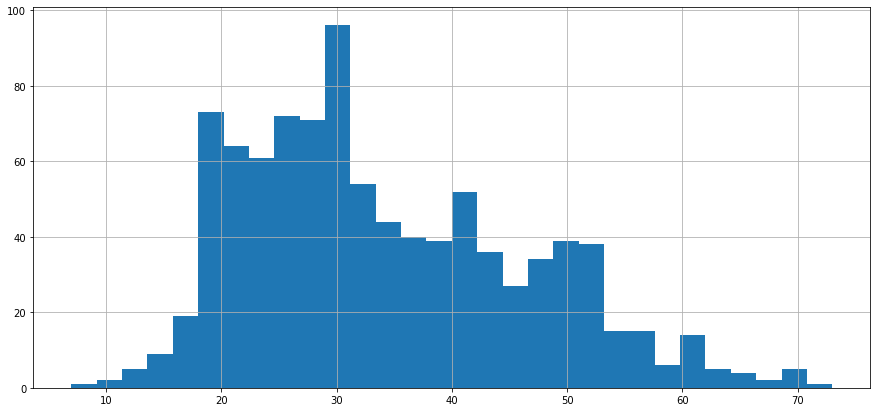

In [67]:
demographics.age.hist(bins=30)

- Mostly young users

In [68]:
demographics.groupby('gender').size()/demographics.userId.nunique()

gender
F    0.289502
M    0.710498
dtype: float64

- Much more male users than woman

In [69]:
(demographics.groupby('occupation').size()/demographics.userId.nunique()).sort_values(ascending=False)

occupation
student          0.207847
other            0.111347
educator         0.100742
administrator    0.083775
engineer         0.071050
programmer       0.069989
librarian        0.054083
writer           0.047720
executive        0.033934
scientist        0.032874
artist           0.029692
technician       0.028632
marketing        0.027572
entertainment    0.019088
healthcare       0.016967
retired          0.014846
lawyer           0.012725
salesman         0.012725
none             0.009544
homemaker        0.007423
doctor           0.007423
dtype: float64

- 1/5th of users are students. The rest of the users are distributed evenly

__Check correlations__

Age and occupation: 

In [70]:
def boxplot_sorted(df, by, column):
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    meds = df2.median().sort_values()
    df2[meds.index].boxplot(rot=90)

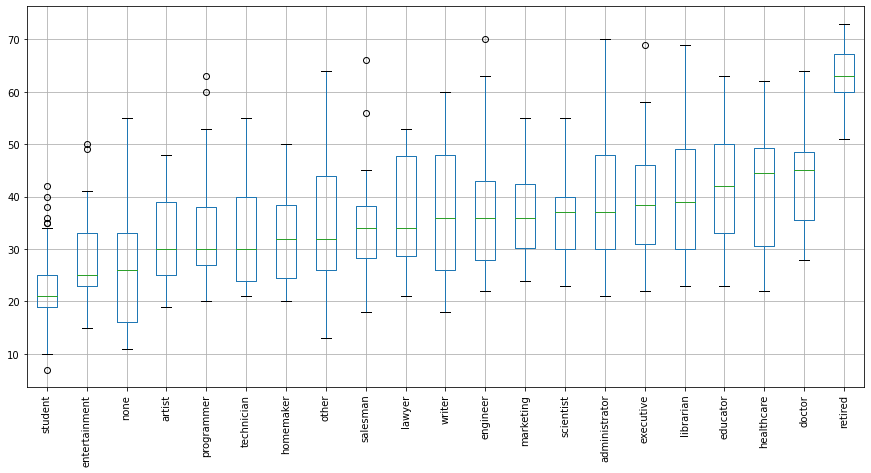

In [71]:
boxplot_sorted(demographics, "occupation", 'age')

- As expected, there is a correlation. Students have much lower ages, and age increases for a few top-level jobs as doctors or educators (retired are at the top clearly)

Age and Gender: 

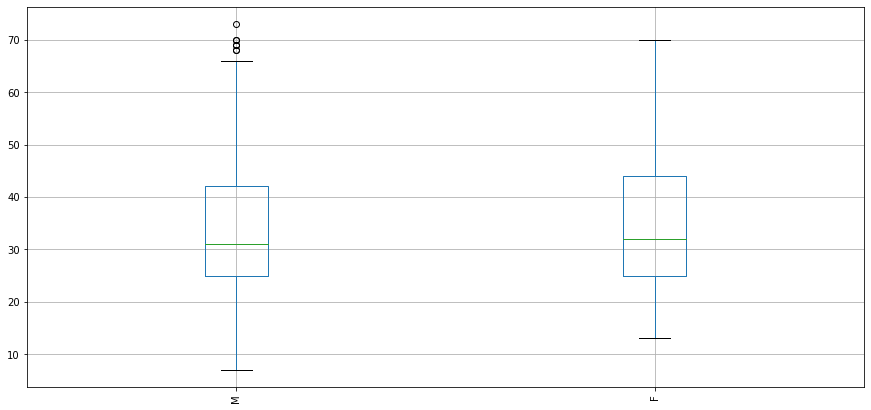

In [72]:
boxplot_sorted(demographics, "gender", 'age')

No correlation

Occupation and Gender

<AxesSubplot:xlabel='occupation'>

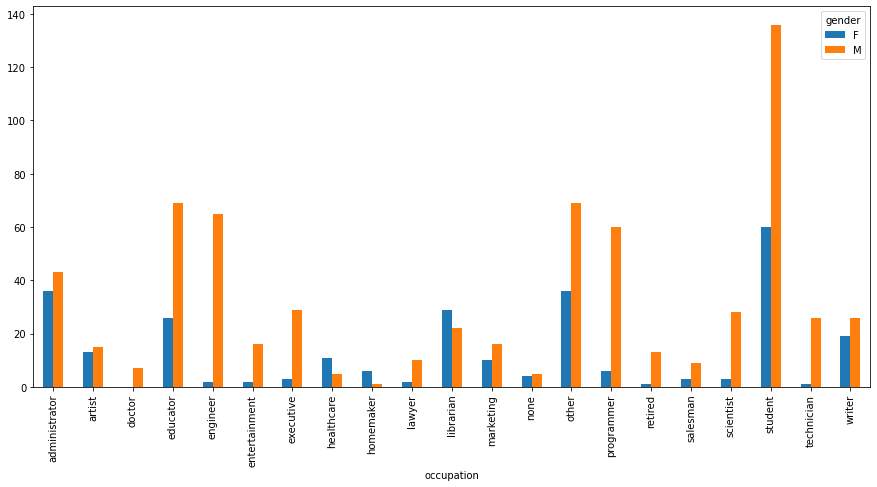

In [73]:
demographics.groupby(['occupation', 'gender']).size().unstack(1).plot.bar()

Convert zip codes to coordinates for visual analysis

In [74]:
nomi = pgeocode.Nominatim('us')
geolocation = nomi.query_postal_code(demographics.zip_code.values)[['place_name', 'state_name', 'latitude', 'longitude']]
geolocation.index = demographics.userId

This is the resulting information: 

In [75]:
geolocation.head()

,place_name,state_name,latitude,longitude
userId,,,,
1,Tucson,Arizona,32.2127,-110.8829
2,Mountain View,California,37.4056,-122.0775
3,Orange Park,Florida,30.1661,-81.7065
4,Maumee,Ohio,41.5817,-83.6628
5,Pittsburgh,Pennsylvania,40.4440,-79.9552


Merge: 

In [76]:
demographics = demographics.merge(geolocation, on='userId', how='left')

In [77]:
demographics.head()

,userId,age,gender,occupation,zip_code,place_name,state_name,latitude,longitude
0,1,24,M,technician,85711,Tucson,Arizona,32.2127,-110.8829
1,2,53,F,other,94043,Mountain View,California,37.4056,-122.0775
2,3,23,M,writer,32067,Orange Park,Florida,30.1661,-81.7065
3,4,24,M,technician,43537,Maumee,Ohio,41.5817,-83.6628
4,5,33,F,other,15213,Pittsburgh,Pennsylvania,40.4440,-79.9552


In [81]:
# demographics.to_csv('./Data/u.user_v2.csv', index=False)

Check coordinates:

In [55]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

<AxesSubplot:>

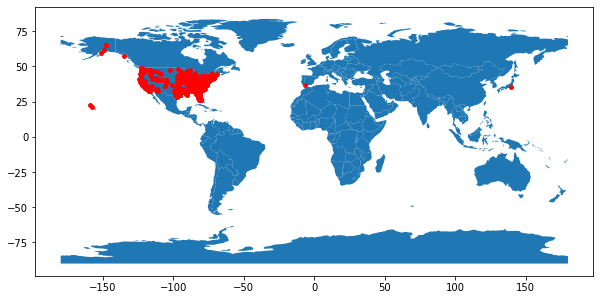

In [57]:
geometry = [Point(xy) for xy in zip(demographics['longitude'], demographics['latitude'])]
gdf = GeoDataFrame(demographics, geometry=geometry)   
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15) 

Only few users appear to be from other parts of the world. Check in the US: 

In [58]:
stats = ratings.groupby('userId').rating.agg([np.mean, 'size'])
user_information = stats.merge(demographics, on='userId', how='left')

<AxesSubplot:>

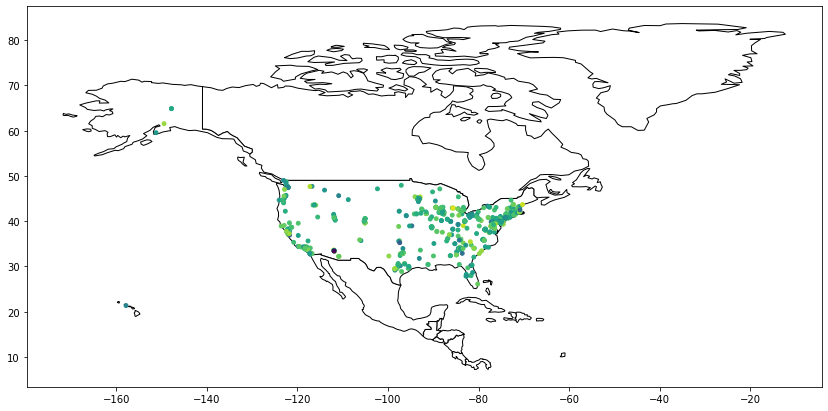

In [59]:
user_information = user_information[user_information['longitude'] < -50]
geometry = [Point(xy) for xy in zip(user_information['longitude'], user_information['latitude'])]
gdf = GeoDataFrame(user_information, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world[world.continent == 'North America'].plot(
    color='white', edgecolor='black')
gdf.plot(ax=ax, marker='o', c=user_information['mean'], markersize=15) 

No clear trend of averages given the same number of users. Check for categories: 

In [60]:
categories = movies.columns[3:].values
preferred_genre = ratings.merge(movies, on='movieId', how='left').groupby('userId')[categories].sum().apply('idxmax', 1)

# Encode for viz
encoder = OrdinalEncoder()
encoded = encoder.fit_transform(preferred_genre.values.reshape(-1, 1))
preferred_genre = pd.DataFrame(encoded.reshape(610), index=preferred_genre.index)

# Merge
user_information = preferred_genre.merge(demographics, on='userId', how='left')

In [89]:
preferred_genre['preferred_genre'] = encoder.inverse_transform(preferred_genre)
# preferred_genre.drop(0, axis=1).to_csv('./Data/prefered_genre.csv')

<AxesSubplot:>

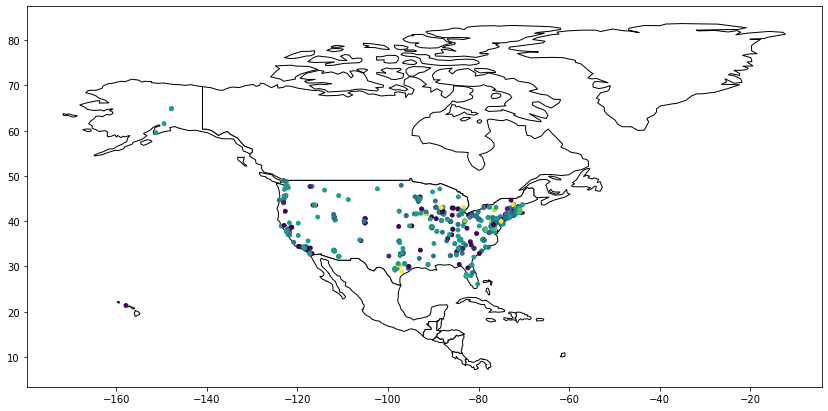

In [61]:
user_information = user_information[user_information['longitude'] < -50]
geometry = [Point(xy) for xy in zip(user_information['longitude'], user_information['latitude'])]
gdf = GeoDataFrame(user_information, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world[world.continent == 'North America'].plot(
    color='white', edgecolor='black')
gdf.plot(ax=ax, marker='o', c=user_information[0], markersize=15) 

No speific trend

## User-Item Data

### Tags

In [217]:
tags = pd.read_csv("./Data/tags.csv")
tags.shape

(1108997, 4)

Tags are user-generated metadata about movies. Each tag is typically a single word or short phrase. The meaning, value, and purpose of a particular tag is determined by each user. 

The tag genome is a data structure that contains tag relevance scores for movies.  The structure is a dense matrix: each movie in the genome has a value for *every* tag in the genome.The tag genome encodes how strongly movies exhibit particular properties represented by tags (atmospheric, thought-provoking, realistic, etc.). The tag genome was computed using a machine learning algorithm on user-contributed content including tags, ratings, and textual reviews.

In [218]:
tags.nunique()

userId        19325
movieId       45981
tag           74714
timestamp    911869
dtype: int64

We have much more users using this. We need to only keep tags which userID and movieID are in our data: 

In [219]:
tags = tags[(tags.userId.isin(ratings.userId.unique())) & (tags.movieId.isin(ratings.movieId.unique()))]
tags.shape

(1250, 4)

Decreased the number of tags significantly: 

In [220]:
tags.tag.nunique()

822

We need to do preprocessing with the tags to group them

In [221]:
tags.tag.value_counts().head(100)

ohsoso                     46
Slashy                     15
sci-fi                     12
boring                     12
dark comedy                11
                           ..
not funny                   2
heroin                      2
quirky                      2
addiction                   2
mother-son relationship     2
Name: tag, Length: 100, dtype: int64

Some are used over a lot of movies. Set same case: 

In [222]:
tags.tag = tags.tag.apply(lambda x: x.title())

#### Reduce Cardinality of Tags

__Attempt 1__ Compute Levenshtein distance between words and do affinity propagation: 

In [223]:
unique_tags = tags.tag.unique()
lev_similarity = -1*np.array([[distance.levenshtein(w1,w2) for w1 in unique_tags] for w2 in unique_tags])

In [224]:
affprop = AffinityPropagation(affinity="precomputed", damping=0.90, random_state=42)
affprop.fit(lev_similarity)
for cluster_id in np.unique(affprop.labels_):
    exemplar = unique_tags[affprop.cluster_centers_indices_[cluster_id]]
    cluster = np.unique(unique_tags[np.nonzero(affprop.labels_==cluster_id)])
    cluster_str = ", ".join(cluster)
    print(" - *%s:* %s" % (exemplar, cluster_str))

 - *Space Action:* Drug Addiction, Dwayne Johnson, Samuel L Jackson, Scarlett Johansson, Science Fiction, Slice Of Life, Space Action, Space Epic, Space Travel
 - *Classic Sci-Fi:* Class Sci-Fi, Classic Horror, Classic Sci-Fi, Thoughtful Sci-Fi
 - *Overrated:* A Little Dated, Lighthearted, Love Triangles, No Narrative, Oscar Nunez, Over-Hyped, Over-The-Top, Overrated, Overrrated
 - *Post-Traumatic Stress Disorder:* Post-Traumatic Stress Disorder
 - *Suprises Around Every Corner:* Suprises Around Every Corner
 - *Too Long:* Chowyoungfat, Far Too Long, Good Acting, Ken Jeong, Not Funny, The One, Thought Provoking, Thought-Provoking, Todd Solondz, Tom Hanks, Tom Holland, Too Dumb To Live, Too Long, Touching
 - *Mary Elizabeth Winstead:* Mary Elizabeth Winstead
 - *Michael Cera:* Big Damn Heroes, Michael B. Jordan, Michael Cera, Michael Pena, Michelle Rodriguez
 - *Video Games:* Andrew Garfield, Time Travel, Video Game Adaptation, Video Games, Videogame
 - *Predictable:* Believable, Mediev

From visual interpretation, sometimes words in a similar cluster are consistent: 
- *Dark Comedy:* Black Comedy, Dark Comedy, Dark Humor, Horror Comedy, Romantic Comedy

Sometimes not so good.... 
- *Zombies:* Bomb Disposal, Complex, Homosexual, Japanese, Junkies, Loneliness, Rob Zombie, Robbie Amell, Robotics, Tom Hiddleston, Zombie, Zombies


__Consider improving the model with name-recognition-entity in later iterations if we have time__

__Attempt 2__: Clean them and take the most popular

In [225]:
tags.tag.nunique()

783

Top Tags: 

In [226]:
important_tags = (round(tags.tag.value_counts()/tags.movieId.nunique() * 100, 2)).head(30)
important_tags

Ohsoso              13.86
Boring               4.52
Slashy               4.52
Sci-Fi               4.22
Funny                3.61
Dark Comedy          3.61
Superhero            3.01
Black Comedy         3.01
Violence             2.71
Romance              2.41
Disturbing           2.41
Satire               2.11
Horror               2.11
Pixar                2.11
Overrated            2.11
Twist Ending         2.11
Mindfuck             2.11
Surreal              1.81
Psychological        1.81
Adventure            1.81
Violent              1.81
80S                  1.81
Stupid               1.51
Dark                 1.51
Nudity (Topless)     1.51
Dystopia             1.51
Stylized             1.51
Post-Apocalyptic     1.51
Classic              1.51
Slow                 1.51
Name: tag, dtype: float64

Check the most recurrent tag, if many users use it: 

In [227]:
tags[tags.tag == "Ohsoso"].userId.unique()

array([268])

Of course, only one troll uses it. Take it away

In [228]:
tags = tags[~(tags.tag == "Ohsoso")]

In [229]:
important_tags = (round(tags.tag.value_counts()/tags.movieId.nunique() * 100, 2)).head(10)
important_tags

Boring          5.15
Slashy          5.15
Sci-Fi          4.81
Dark Comedy     4.12
Funny           4.12
Superhero       3.44
Black Comedy    3.44
Violence        3.09
Disturbing      2.75
Romance         2.75
Name: tag, dtype: float64

Check if they are representative within the dataset (a lot of users use them)

In [230]:
print(f"Percentage of Users that use tags: {round(tags.userId.nunique()/ratings.userId.nunique() * 100, 2)}%")

Percentage of Users that use tags: 7.38%


Only a few users use tags. Will not serve for our analysis. Dont't use tags

### Tag-Genome

We have 1,128 tags, and >58,000 movies, so quite a lot of numbers: 

In [231]:
genome_scores = pd.read_csv("./Data/genome-scores.csv")
genome_tags = pd.read_csv("./Data/genome-tags.csv")

In [232]:
genome_scores = genome_scores[genome_scores.movieId.isin(ratings.movieId.unique())]

In [233]:
top_relevance = genome_scores.sort_values(['movieId', 'relevance'], ascending=[True, False]).groupby('movieId').first().reset_index()

Problems with getting most relevant tags: 

Too many tags: 

In [234]:
top_relevance.tagId.nunique()

783

Some movies don't have tags: 

In [235]:
top_relevance.movieId.nunique()/ratings.movieId.nunique()

0.897573015220074

Genome tags represent Item information: it is aggregated by all of the user tags, and does the relevance of each of the tags for the movies. In this sense, it looses the user-item interaction that we have if we would use only the tag that eachuser put on the movies. This is why we will go for using only the top tags that users put on movies, and not the genome tag

# Denormalize the Data

Information that will be included in the final ABT: 
- Ratings
- Item Data: 
    - Title
    - Genre
    - Year
- User Data: 
    - Demographics

In [236]:
data = ratings.drop('timestamp', axis=1).merge(movies, how='left', on='movieId') .\
                                         merge(demographics, how='left', on='userId')

Check missing values: 

In [237]:
data.isna().sum()

userId               0
movieId              0
rating               0
sample_ratings       0
ratings2             0
outlier              0
title                0
year                18
Action               0
Adventure            0
Animation            0
Children             0
Comedy               0
Crime                0
Documentary          0
Drama                0
Fantasy              0
Film-Noir            0
Horror               0
IMAX                 0
Musical              0
Mystery              0
Romance              0
Sci-Fi               0
Thriller             0
War                  0
Western              0
age                  0
gender               0
occupation           0
zip_code             0
place_name        5097
state_name        5097
latitude          5097
longitude         5097
dtype: int64

Impute years with mean: 

In [238]:
data['year'] = data.year.fillna(int(data.year.mean()))

CHeck how many users to not have geolocation: 

In [239]:
(data.groupby('userId').place_name.apply(lambda y: y.isna().sum()) > 0).sum()

19

19 users with missing geolocation information. Could impute using expected value, or look manually for the information as the volume of users is not too big. See if there is a place users are mostly from: 

In [240]:
demographics[demographics.userId.isin(ratings.userId.unique())].place_name.value_counts()

Saint Paul     20
Minneapolis    18
New York       16
Washington     10
Columbus        9
               ..
New Haven       1
Coram           1
Florissant      1
Minnetonka      1
Halethorpe      1
Name: place_name, Length: 376, dtype: int64

The max place users are from is Saint Paul with 20 users. Imputing with Saint Paul would be doubling this quantity, biasing the data. Try out this altenative still: 

In [242]:
# data.to_csv('./Data/data_content_based_v1.csv', index=False)

# Next Steps

__Overall Data__
- Fill missing values for 19 missing users (could check postal code manually as volume is low)

__Ratings Data__
- Consider sampling the number of rated movies from these extreme cases (users that rated almost every movie)
- Consider including movies rated with decimals in the rounding to the nearest decimal
- Consider excluding a black sheep user from the dataset (that one bitch that gave terrible ratings)
- Consider treating the ratings as ordinal and not numerical

__Item Data__
- Fill the missing values for years
- Extract other relevant features through web-scarping and the links dataset

__User Data__
- ... 

__User-Item Data__
- Find a way to incorporate tag genome score without drastically increasing the dimensionality